In [1]:
"""Errors might remain if Kernel is not restarted"""
"""Changes to local modules might not update if Kernel is not restarted"""

'Changes to local modules might not update if Kernel is not restarted'

In [2]:
""" Necessary modules """
from matplotlib.backends.backend_pdf import PdfPages
from Methods.classify import split_data, plotClass, plotClass_separated
from Methods.miasa_class import Miasa_Class

In [3]:
""" Name and origin of dataset """
DataName = "GRN_data"
from Methods.simulate_class_data import load_data_twoGRN

In [4]:
""" Euclidean embedding pameters only used in MIASA (includes a finite number of auto adjustements)
    
    if custom, then type dictionary 
    c_dic = {"c1":float, "c2":float, "c3":float} 
"""
c_dic = "default" 

""" Load or Generate data: 
    
    Required:
    X and Y are separated datasets with M, N samples, respectively, with each samples containing K realizations
    X.shape = (M, K) 
    Y.shape = (N, K)
    num_clust = number of clusters
    dtp : tuple (datatype X_vars , datatype Y_vars) is needed for visualization only
    

    Not Required:
    X_vars, Y_vars = Labels of X and Y samples
    Class_True = True cluster labels of samples
    
"""
palette = "Set2"# seaborn color palette for true clusters (make sure not to use cyclic color maps)
data_dic_orig, class_dic, num_clust, dtp = load_data_twoGRN(var_data = False, palette = palette)
X, Y, Class_True, X_vars, Y_vars = split_data(data_dic_orig, class_dic, separation = True) # separation = False always for generate_data_dist

In [5]:
"""
Parameters of MIASA
"""

metric_method = ("eCDF", "Granger-Cause-diff-chi2") # (Similarity, Association) distance models
clust_method = "Agglomerative_ward" # clustering aglorithm to use
palette = "Spectral" # seaborn color palette
dist_origin = (True,False) # for datasets (X, Y) decide if the distance to the origin of the axes is interpretable as the norm of the feature representations of the samples
in_threads = False # True to avoid broken runs when using parallel jobs (relevant only for class_experiments)

In [6]:
"""
If desired custom similarity feature representation (defining Euclidean similarity distance) 
and association measures then 

1) set 
    metric_method = "precomputed"
2) give Feature_dic as parameter
    Feature_dic["Feature_X"] : array similarity features of dataset X: M samples and L features, X.shape = (M, L)
    Feature_dic["Feature_Y"] : array similarity features of dataset Y: M samples and S features, Y.shape = (N, S)
    Feature_dic["Asssociation_function"] : a function of argument tuple full datasets (X, Y) or pair of samples (X_i, Y_j) computing the pairwise association between the samples of X and Y
    
    Feature_dic["assoc_func_type"] : type of the association function as options
                                    option 1: str vectorized     : argument full datasets (X, Y) => return directly the Asscociation distance matrix of shape (M, N) 
                                    option 2: str not_vectorized : argument samples (X_i, Y_j)   => return a scalar = Associaiton distance between sample X_i and sample Y_j

    Feature_dic["DMat"]  : array distance function, then Feature_dic["Asssociation_function"] Feature_dic["assoc_func_type"] can be set to None 
    Feature_dic["dist_origin"]: bool tuple (X?, Y?) deciding if the distance to the origin of the axes is interpretable as the norm of the feature representations of the samples
                                Must be in aggreement with given Feature_dic["DMat"]
                                if any (X?, Y?) then shape Feature_dic["DMat"].shape = (M+N+1, M+N+1) and distance to origin is placed at the M+1-th row (see function Methods.Core.CosLM.Prox_Mat)

example:
    
from Methods.Generate_Features import eCDF, get_assoc_func
metric_method = "precomputed"
Feature_dic = {} 
Feature_dic["Feature_X"], Feature_dic["Feature_Y"] = eCDF(X,Y)
Feature_dic["Asssociation_function"], Feature_dic["assoc_func_type"] = get_assoc_func("KS-stat")
Feature_dic["DMat"] = None 
Feature_dic["dist_origin"] = (True,True) ## if DMat is not None it should contain distance to origin setting 
"""
Feature_dic = None

In [7]:
"""
Parameters of MIASA, second example and same as in the first example
"""
import numpy as np
from Methods.Generate_Features import corrcoeff, Sim_GRN, Eucl, Null, eCDF, get_assoc_func
metric_method = "precomputed"
clust_method = "Agglomerative_ward" # clustering aglorithm to use
Feature_dic = {}
#from Methods.Core.Generate_Distances import Association_Distance
#feature_X = Association_Distance((X, X), func = get_assoc_func("Granger-Cause-2diff-chi2")[0], ftype = "not vectorized")
#feature_Y = Association_Distance((Y, Y), func = get_assoc_func("Granger-Cause-2diff-chi2")[0], ftype = "not vectorized")

# compute moving average feature
#feature_X = np.cumsum(X, axis = 1)/np.sum(X, axis = 1)[:, np.newaxis]
#feature_Y = np.cumsum(Y, axis = 1)/np.sum(Y, axis = 1)[:, np.newaxis]
#feature_X = np.zeros(X.shape)
#ind_X = np.arange(X.shape[0]).astype(int)
#for t in range(feature_X.shape[1]):
#    for i in range(feature_X.shape[0]):
#        feature_X[i, t] = np.cov(X[ind_X != i, t])
        
#feature_Y = np.zeros(Y.shape)
#ind_Y = np.arange(Y.shape[0]).astype(int)
#for t in range(feature_Y.shape[1]):
#    for j in range(feature_Y.shape[0]):
#        feature_X[j, t] = np.cov(Y[ind_Y != j, t])
        
Feature_dic["Feature_X"], Feature_dic["Feature_Y"] = Eucl(X, Y) 
Feature_dic["Asssociation_function"], Feature_dic["assoc_func_type"] = get_assoc_func("Granger-Cause-3diff-chi2")
Feature_dic["DMat"] = None 
Feature_dic["dist_origin"] = (True,True)

In [8]:
""" 
Perform MIASA Classification of samples
"""
Id_Class = Miasa_Class(X, Y, num_clust, 
                       dist_origin = dist_origin, 
                       metric_method = metric_method, 
                       clust_method = clust_method, # clustering based on Euclidean embedding and point of origin is not clustered (the characterisits of the embedding makes all points too far from it and it risk to be always considered as one independen cluster)
                       c_dic = c_dic, Feature_dic = Feature_dic,
                       in_threads = in_threads,
                       palette = palette)

import numpy as np
import pandas as pd
print("------------- Some checking ------------")
print("Number of True Clusters/Distributions", len(np.unique(Class_True)), "checked:", num_clust == len(np.unique(Class_True)))
num_col_true = (np.unique(pd.DataFrame(data_dic_orig["true_colors"]).loc[:][:], axis = 1)).shape[1]
print("Number of True colors of clusters", num_col_true, "checked non-cyclic:", num_col_true == num_clust) 

print("Number of predicted clusters", len(np.unique(Id_Class["Class_pred"])), "checked:", num_clust == len(np.unique(Id_Class["Class_pred"])))
num_col_pred = (np.unique(Id_Class["color_clustered"], axis = 0)).shape[0]
print("Number of colors predicted clusters", num_col_pred, "checked non-cyclic:", num_col_pred == num_clust) 

print("------------- Evaluate clustering ------------")
from sklearn.metrics import rand_score, adjusted_rand_score
accuracy_2a = rand_score(Class_True, Id_Class["Class_pred"])
accuracy_3a = adjusted_rand_score(Class_True, Id_Class["Class_pred"])

print("Rand Index", accuracy_2a, "\nAdjusted Rand_Index", accuracy_3a)

Replacement matrix is PSD: success Euclidean embedding
------------- Some checking ------------
Number of True Clusters/Distributions 3 checked: True
Number of True colors of clusters 3 checked non-cyclic: True
Number of predicted clusters 3 checked: True
Number of colors predicted clusters 3 checked non-cyclic: True
------------- Evaluate clustering ------------
Rand Index 0.7585682326621924 
Adjusted Rand_Index 0.4544213366339321


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


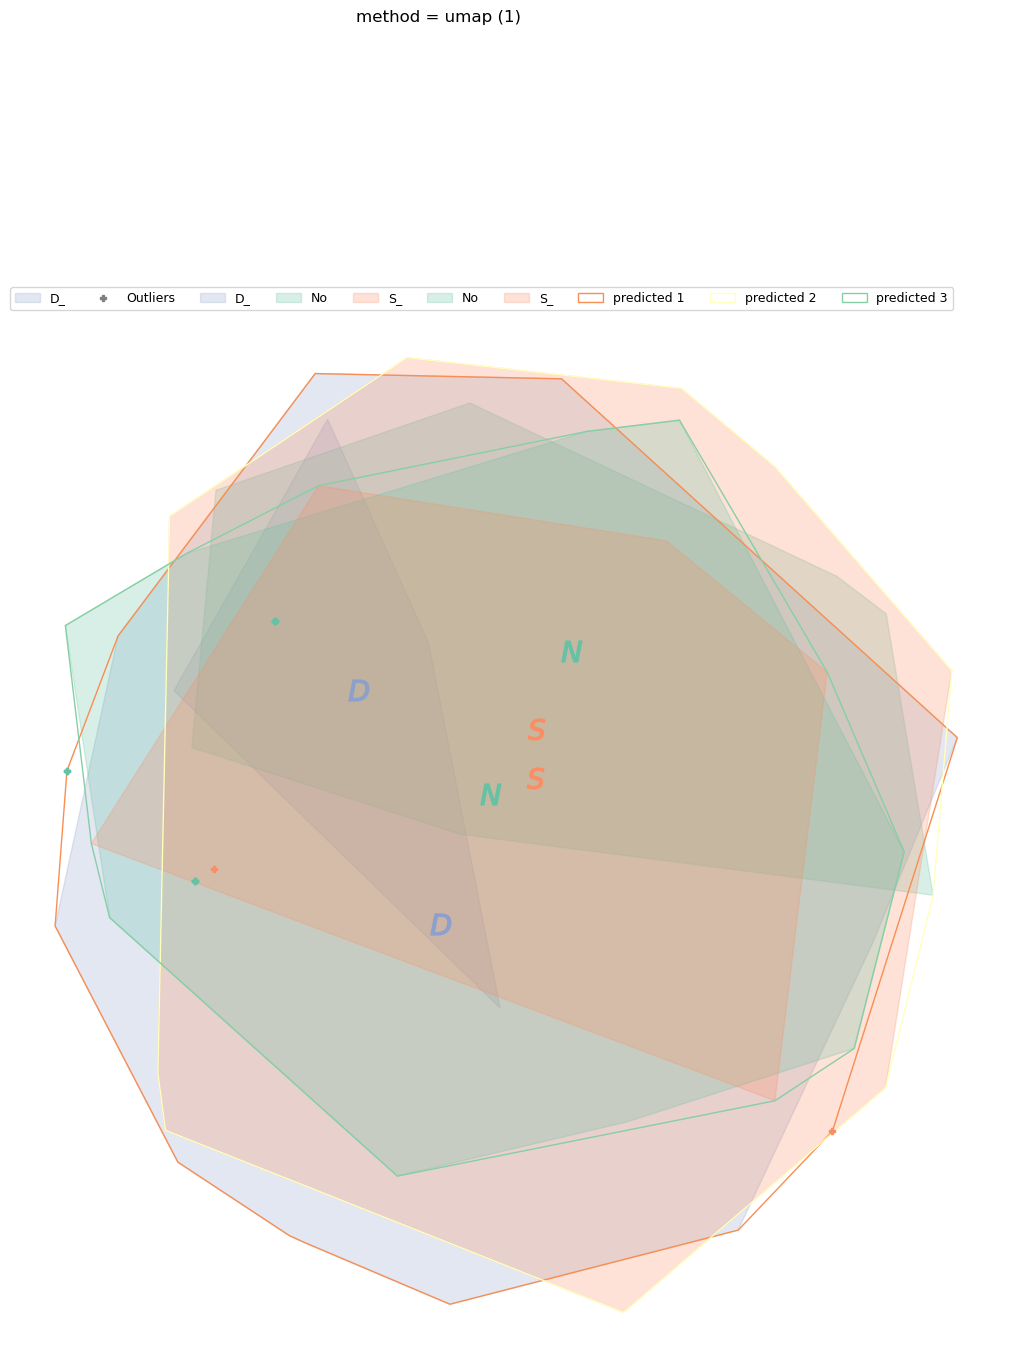

In [9]:
"""
2-Dimensional visualization of clusters (UMAP visualization) 
- all predicted classes 
- colored predicted classes or true classes 
"""
pdf= PdfPages("Figures/"+DataName+"_UMAP.pdf")
fig, ax = plotClass(Id_Class, X_vars, Y_vars, pdf, dtp,
          run_num = 1, n_neighbors = 20, min_dist = 0.99, 
          method = "umap", 
          scale = False, # scale = "pca", "standard", anything esle is taken as no scaling 
          cluster_colors = False, # chosed_color: if False, true_colors bellow must be given 
          true_colors = data_dic_orig["true_colors"],# give a true class colors as dictionary with X_vars and Y_vars as key
          markers = [(" ",5),(" ",5)], # optional markers list and their size for X and Y
          show_labels = False, # optional show the labels of X and Y
          show_orig = False, #optional show the the axis lines going through embedded origin 
          legend = True, # add legend only if true cluster are required
          wrap_true = True, # wrapp the members of a true cluster , in each indentified clusters
          group_annot_size = 15, ### size of the annotations in the center of polygones‚
          wrap_predicted = True, # full lines to wrap around the predicted cluster
          show_pred_outliers = False, #
          def_pred_outliers = (3, 0.75), # (a, b), greater than a*std of pairwise dist for more than b*100% of the points in the predicted class
          oultiers_markers = ("P", "^", 5), # (true, predicted, size)
          wrap_type = "convexhull", # convexhull or ellipse (ellipse does not look accurate)
          dataname = "GRN") # true cluster markers for this simulation
import matplotlib.pyplot as plt
pdf.savefig(fig, bbox_inches = "tight")
plt.legend(loc = (0,1), fontsize = 9, ncol = 10)
plt.show()

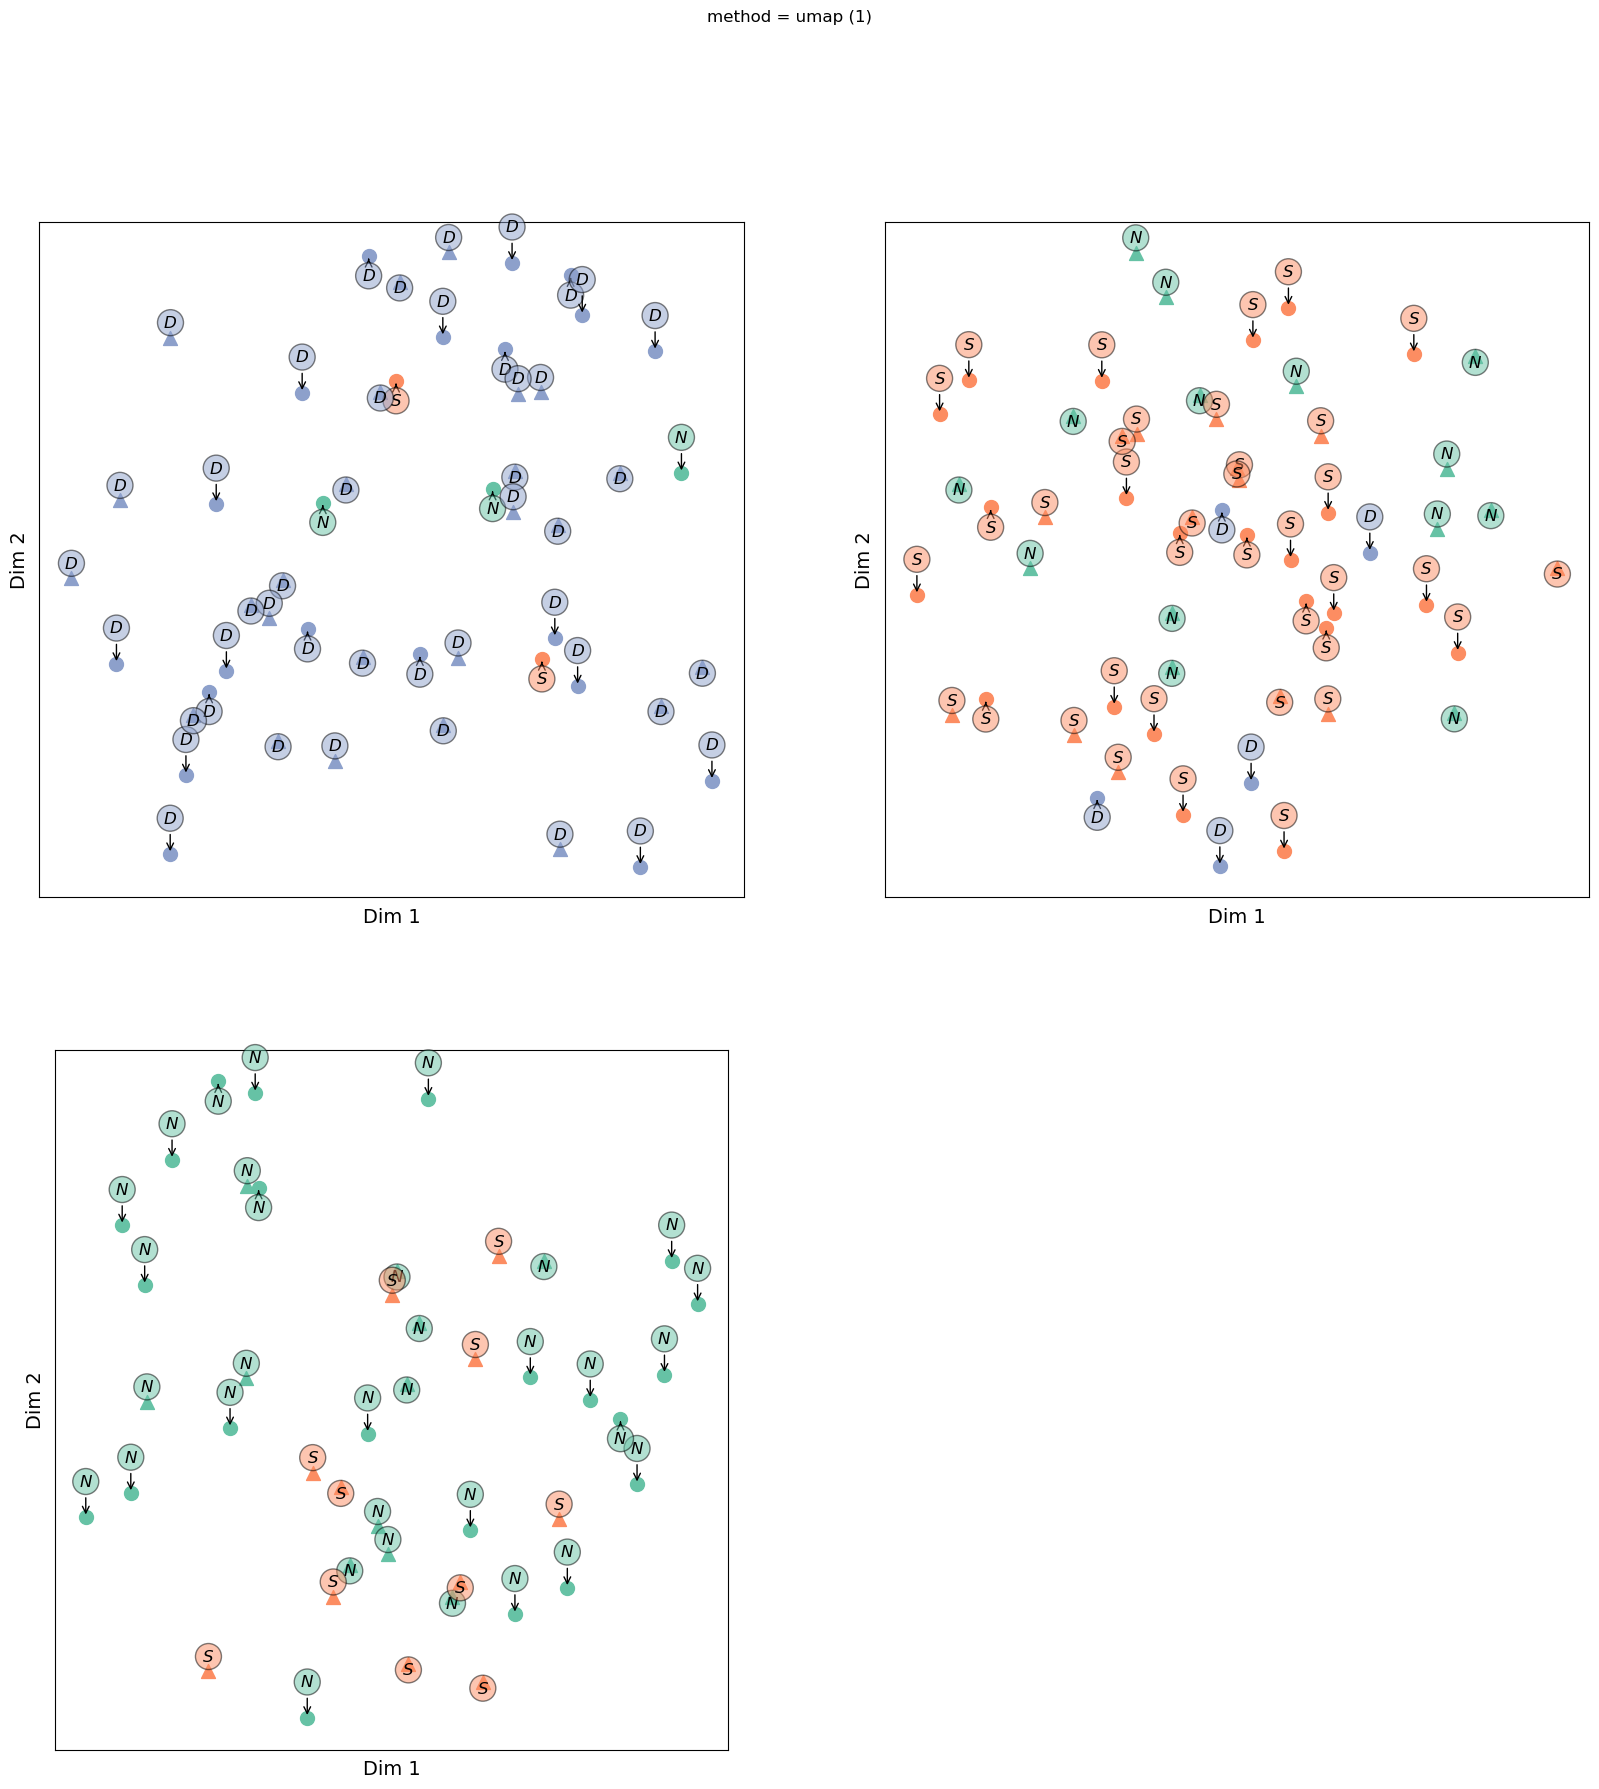

In [10]:
"""2-Dimensional visualization visualization of clusters (UMAP visualization) 
- separated predicted classes 
- colored true classes
"""
fig, ax = plotClass_separated(Id_Class, X_vars, Y_vars, pdf, dtp,
          run_num = 1, n_neighbors = 20, min_dist = 0.99, 
          method = "umap",
          scale = False, # scale = "pca", "standard", anything esle is taken as no scaling 
          cluster_colors = False, # if False, true_colors bellow must be given 
          true_colors = data_dic_orig["true_colors"], # give a true class colors as dictionary with X_vars and Y_vars as key
          markers = [("o",100),("^",100)], # optional markers list and their size for X and Y
          sub_fig_size = 10, # optional sub figure size (as a square)
          show_labels = True, # optional show the labels of X and Y
          show_orig = False, # optional show the the axis lines going through origin 
          show_separation = True, # optional separate all subfigs
          num_row_col = (2, 2),  # number of subfigs in row and col
          dataname = "GRN") # true cluster markers for this simulation
pdf.close() # save everything 
plt.show()              

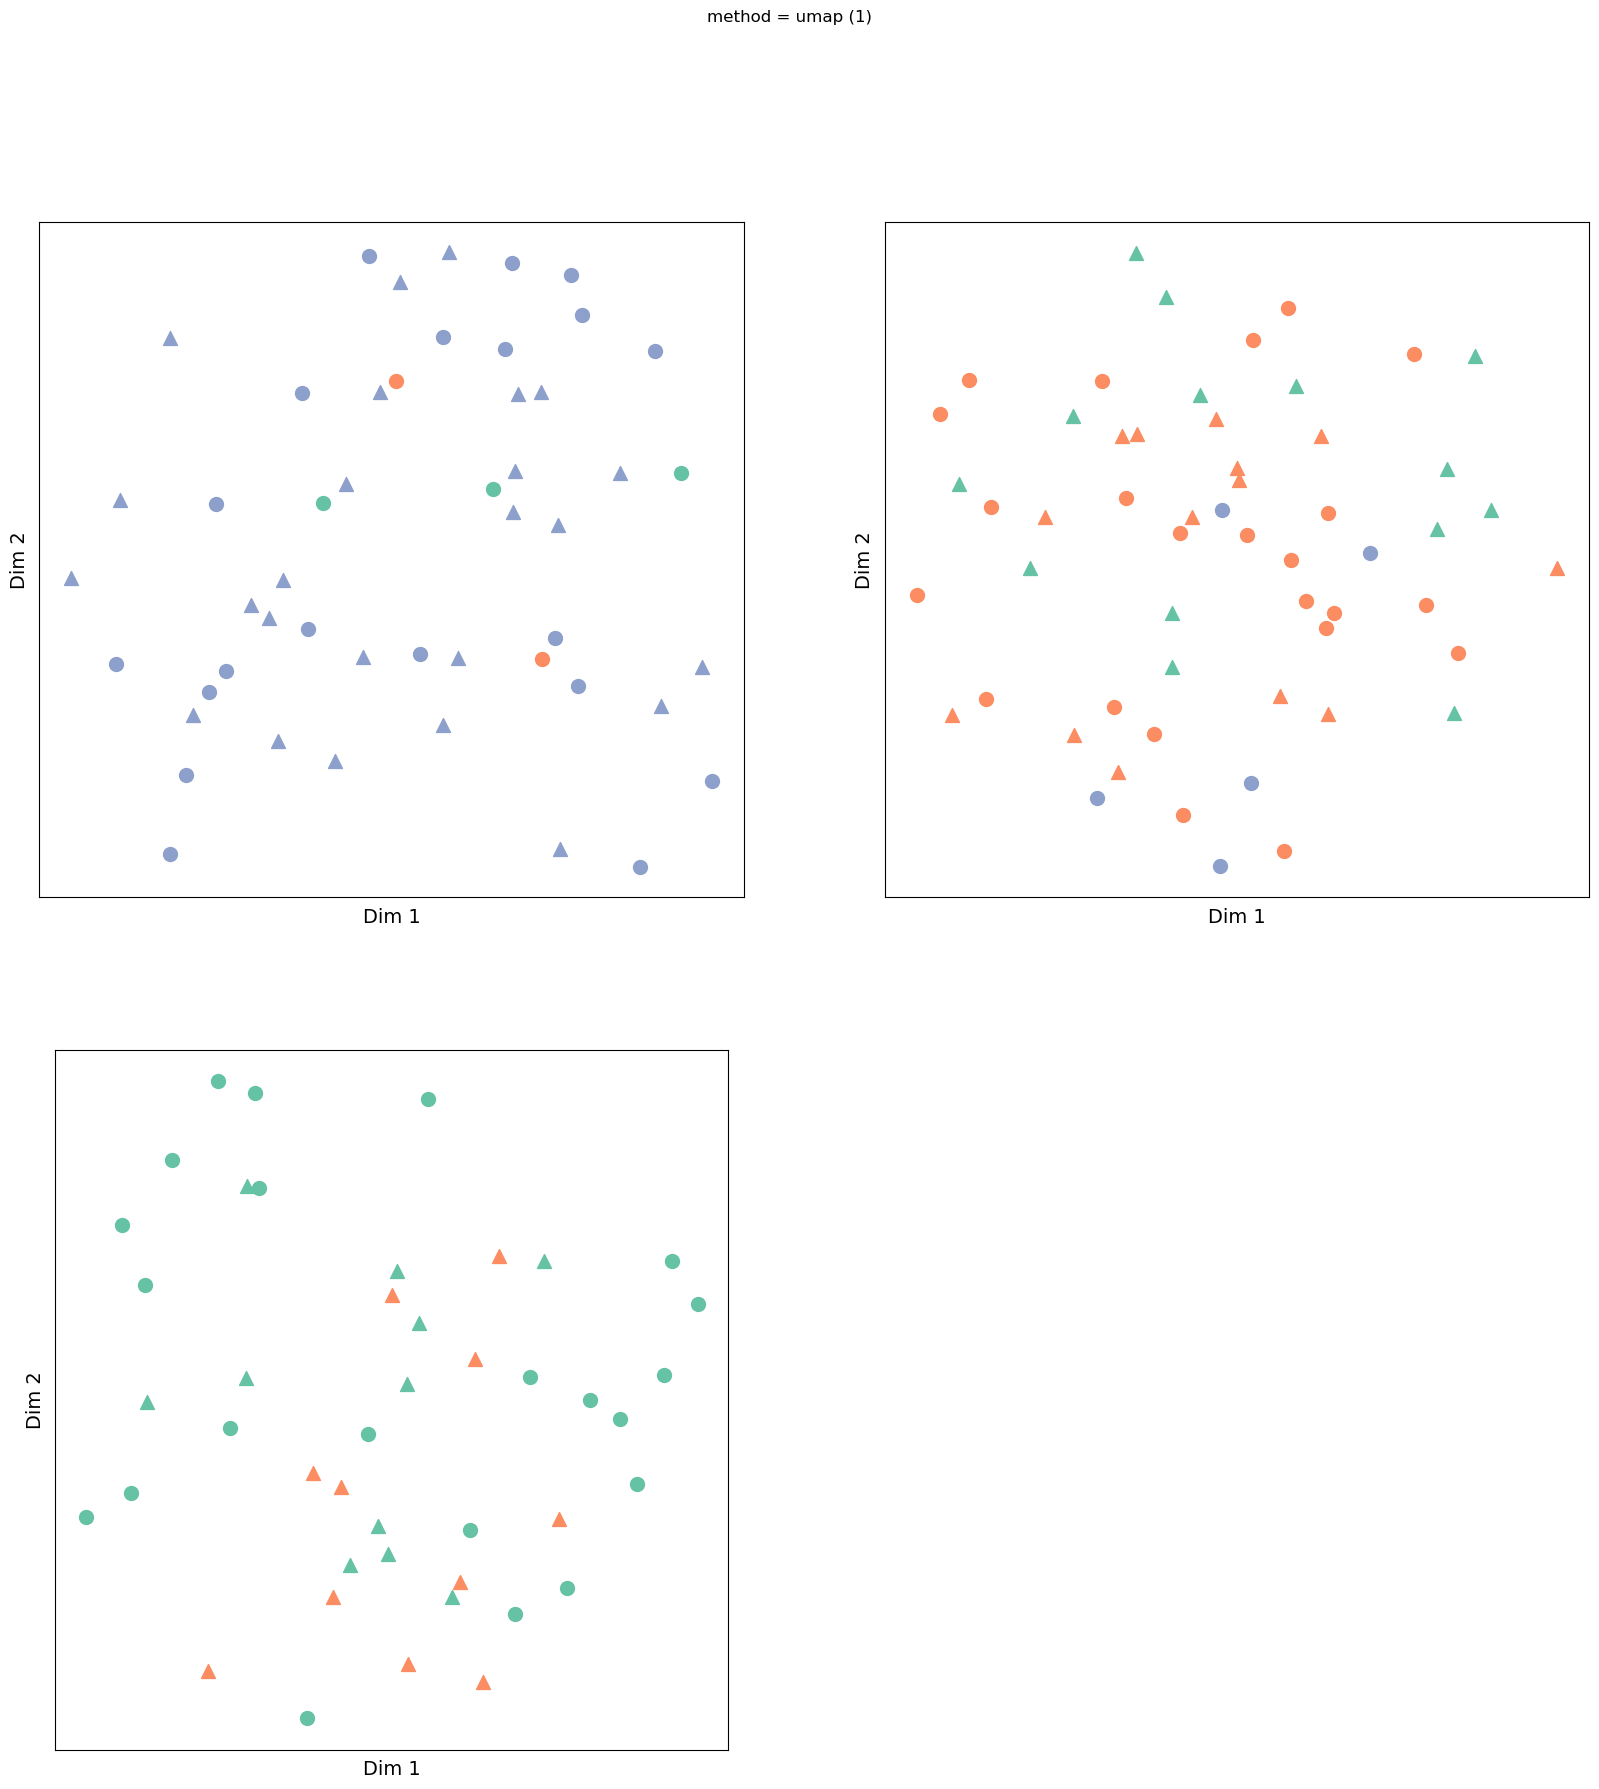

In [11]:
"""2-Dimensional visualization visualization of clusters (UMAP visualization) 
- separated predicted classes 
- colored true classes
"""
pdf = PdfPages("Figures/"+DataName+"_UMAP.pdf")
fig, ax = plotClass_separated(Id_Class, X_vars, Y_vars, pdf, dtp,
          run_num = 1, n_neighbors = 50, min_dist = 0.99, 
          method = "umap",
          scale = False, # scale = "pca", "standard", anything esle is taken as no scaling 
          cluster_colors = False, # if False, true_colors bellow must be given 
          true_colors = data_dic_orig["true_colors"], # give a true class colors as dictionary with X_vars and Y_vars as key
          markers = [("o",100),("^",100)], # optional markers list and their size for X and Y
          sub_fig_size = 10, # optional sub figure size (as a square)
          show_labels = False, # optional show the labels of X and Y
          show_orig = False, # optional show the the axis lines going through origin 
          show_separation = True, # optional separate all subfigs
          num_row_col = (2, 2) )  # number of subfigs in row and col

pdf.savefig(fig, bbox_inches = "tight")
pdf.close() # save everything 
plt.show()    

/Users/raharinirina/opt/anaconda3/envs/macPy3/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/raharinirina/opt/anaconda3/envs/macPy3/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


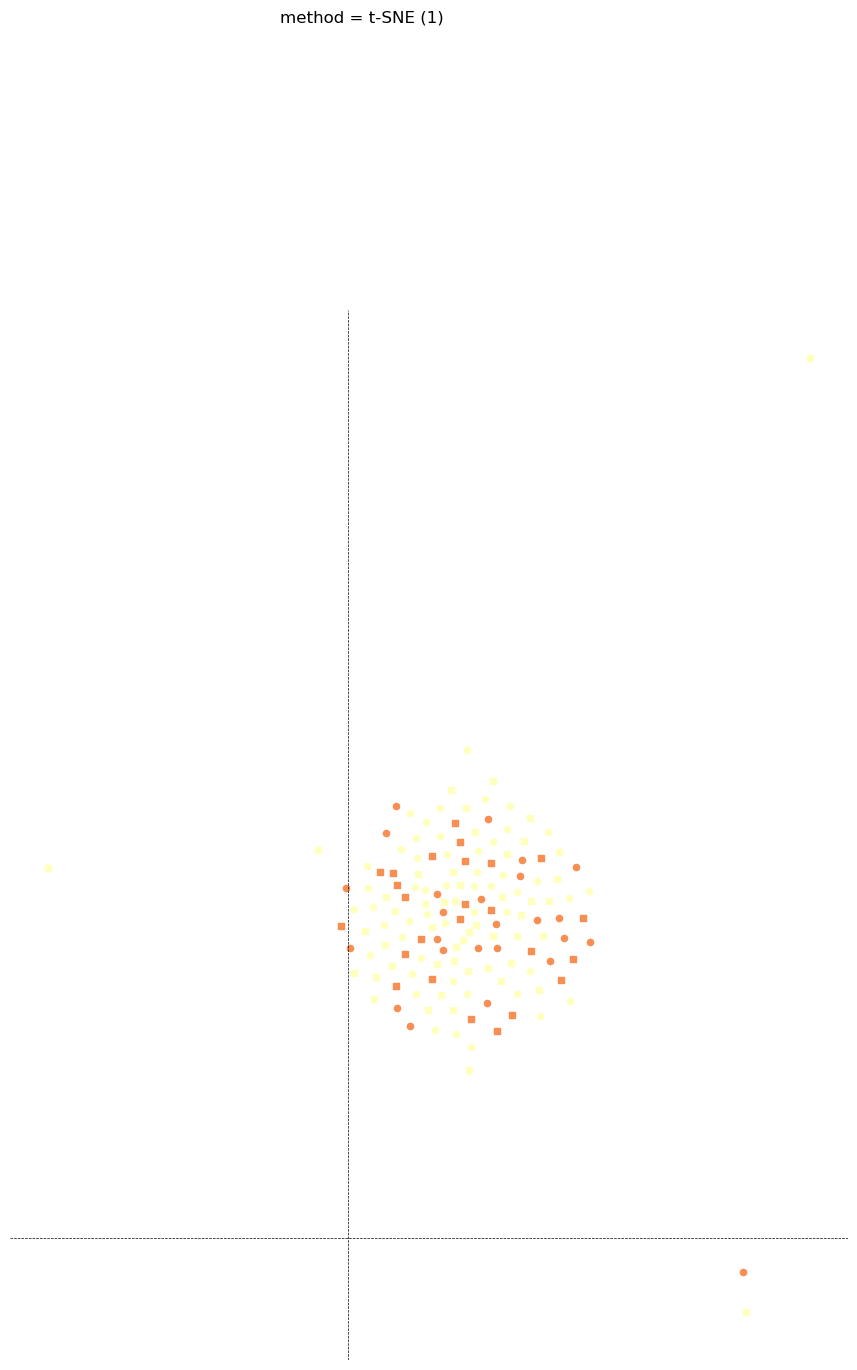

In [12]:
"""
2-Dimensional visualization of clusters (TSNE visualization) 
- all predicted classes 
- colored predicted classes 
"""
pdf= PdfPages("Figures/"+DataName+"_TSNE.pdf")
fig, ax = plotClass(Id_Class, X_vars, Y_vars, pdf, dtp,
          run_num = 1, n_neighbors = 30, 
          method = "t-SNE", scale = False, # scale = "pca", "standard", anything esle is taken as no scaling 
          cluster_colors =  True, # chosed_color: if False, true_colors bellow must be given 
          true_colors =  False,# give a true class colors as dictionary with X_vars and Y_vars as key
          markers = [("o",20),("s",20)], # optional markers list and their size for X and Y
          show_labels = False, # optional show the labels of X and Y
          show_orig = True)# optional show the the axis lines going through origin 
plt.show()

/Users/raharinirina/opt/anaconda3/envs/macPy3/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/raharinirina/opt/anaconda3/envs/macPy3/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


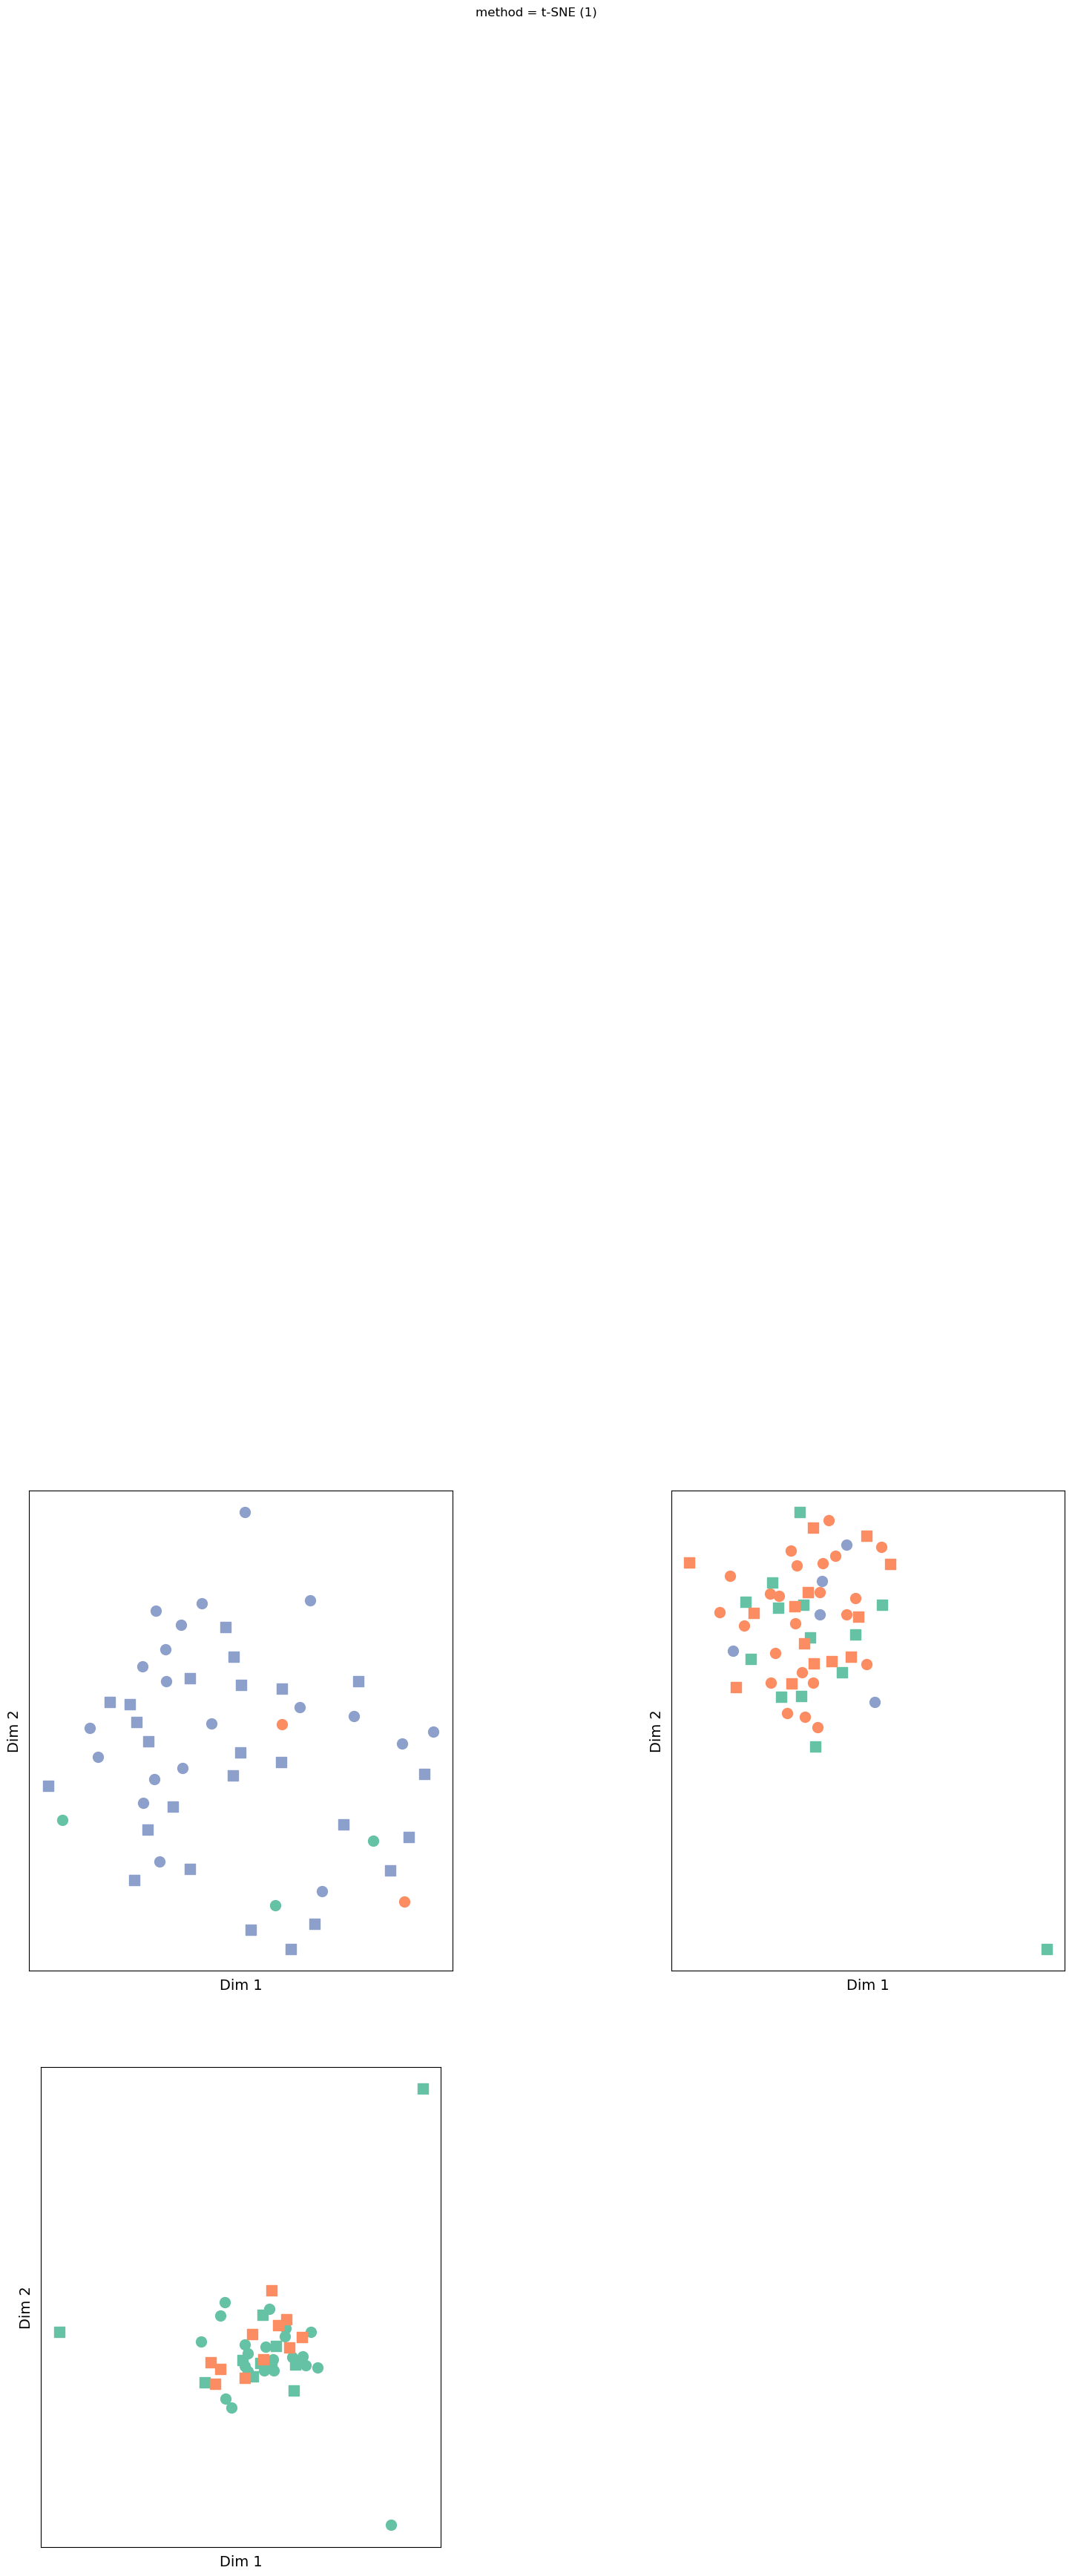

In [13]:
"""
2-Dimensional visualization of MIASA clusters (TSNE visualization) 
- separated predicted classes 
- colored true classes
"""
fig, ax = plotClass_separated(Id_Class, X_vars, Y_vars, pdf, dtp,
          run_num = 1, n_neighbors = 30, 
          method = "t-SNE", 
          scale = False, # scale = "pca", "standard", anything esle is taken as no scaling 
          cluster_colors = False, # chosed_color: if False, true_colors bellow must be given 
          true_colors = data_dic_orig["true_colors"], # give a true class colors as dictionary with X_vars and Y_vars as key
          markers = [("o",100),("s",100)], # optional markers list and their size for X and Y
          sub_fig_size = 10, # optional sub figure size (as a square)
          show_labels = False, # optional show the labels of X and Y
          show_orig = False, # optional show the the axis lines going through origin
          show_separation = True, # optional separate all subfigs
          num_row_col = (20, 2) )  # number of subfigs in row and col
pdf.close() # save everything                
plt.show()

In [ ]:
"""
Perform analogue non-metric: extract the classification, 
MDS methods based on the distance matrix can be used for visualization (e.g. sklearn.manifold.MDS or t-SNE). 
"""
from Methods.NonMD_class import NonMetric_Class
Id_Class_2 = NonMetric_Class(X, Y, num_clust, 
                       dist_origin = dist_origin,  # including distance to origin is the same as clustering over true feature norm
                       metric_method = metric_method, 
                       clust_method = "Kmedoids", # clustering is based on distance matrix including info in dist_origin (it is not Euclidean thus we can't use Kmeans)
                        Feature_dic = Feature_dic,
                       in_threads = in_threads,
                       palette = palette)

print("------------- Evaluate clustering ------------")
accuracy_2b = rand_score(Class_True, Id_Class_2["Class_pred"])
accuracy_3b = adjusted_rand_score(Class_True, Id_Class_2["Class_pred"])
print("Rand Index", accuracy_2b, "\nAdjusted Rand_Idex", accuracy_3b)

"""
2-Dimensional visualization of clusters (MDS visualization) 
- all predicted classes 
- colored predicted classes 
"""
nonMD_low = "t-SNE"
pdf = PdfPages("Figures/"+DataName+"_NonMD_%s.pdf"%nonMD_low)
fig, ax = plotClass(Id_Class, X_vars, Y_vars, pdf, dtp,
          run_num = 1, n_neighbors = 30,
          method = nonMD_low, 
          scale = False, # scale = "pca", "standard", anything esle is taken as no scaling 
          cluster_colors = True, # chosed_color: if False, true_colors bellow must be given 
          true_colors = False,# give a true class colors as dictionary with X_vars and Y_vars as key
          markers = [("o",20),("s",20)], # optional markers list and their size for X and Y
          show_labels = False, # optional show the labels of X and Y
          show_orig = True, # optional show the the axis lines going through origin  
          metric = "precomputed") # Necessary option for non-Metric, use Distance matrix
pdf.close()
plt.show()

In [ ]:
#clust_method_2 = "Simple_Min_Dist"
from Methods.NonMD_class import NonMetric_Class
from sklearn.metrics import accuracy_score
#clust_method_2 = MLPClassifier, (len(X), len(Y), Class_True, 75) # NN Classifier learns from distance matrix, requires true classes and we use x%(e.g:0.75) of original data as training set
"""
clust_method_2b = "Kmedoids"
Id_Class_2b = NonMetric_Class(X, Y, num_clust, 
                       dist_origin = dist_origin, 
                       metric_method = metric_method, 
                       clust_method = clust_method_2b, 
                        Feature_dic = Feature_dic,
                       in_threads = in_threads,
                       palette = palette)

accuracy_1b = accuracy_score(Class_True, Id_Class_2b["Class_pred"])
accuracy_2b = rand_score(Class_True, Id_Class_2b["Class_pred"])
accuracy_3b = adjusted_rand_score(Class_True, Id_Class_2b["Class_pred"])

print("NN Classifier Accuracy:", accuracy_1b, "\nRand Index", accuracy_2b, "\nAdjusted Rand_Index", accuracy_3b)
"""

In [ ]:
# https://www.educative.io/answers/implement-neural-network-for-classification-using-scikit-learn
# https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html#sklearn.neural_network.MLPClassifier
# https://ujjwalkarn.me/2016/08/09/quick-intro-neural-networks/
from sklearn.neural_network import MLPClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
X, y = make_classification(n_samples=100, random_state=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y,random_state=1)
clf = MLPClassifier(random_state=1, max_iter=300).fit(X_train, y_train)
clf.predict_proba(X_test[:1])

In [ ]:
y_pred = clf.predict(X_test)
from sklearn.metrics import confusion_matrix, accuracy_score
# Evaluating the results of the model
accuracy = accuracy_score(y_test,y_pred)*100
confusion_mat = confusion_matrix(y_test,y_pred)

# Printing the Results
print("Accuracy for Neural Network is:",accuracy)
print("Confusion Matrix")
print(confusion_mat)